In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from math import sqrt,cos,acos,pi,exp,sin,atan2,log
from numpy import arange,mean,asarray,isnan,isinf
import pickle as pkl
from scipy import stats

import csv
import sys
import pandas as pd
import os

from DavioPlotter import *

verbose = True

Nickdir = '/home/kmason/fullosc/NicksCode/1L1PSelection/1e1pBDT/'

finalPred = False
fset = 12 # 0 = open data, 1-7 = fake datasets, 8 = High E far sideband, 9 = Low BDT far sideband, 10 = Full near sideband
cutMode = 0 # 0 = Final Selection, 1 = Kin Cut Sample, 2 = High E, 3 = Low BDT, 4 = 
if fset==8: cutMode = 2
if fset==9: cutMode = 3
    
cutmodedir = {0:'FinalSelection',1:'KinCut',2:'HighE',3:'LowBDT'}[cutMode]

lowEpatch = False
vtxCut    = 5

C1_POT = 1.558e+20 + 1.129e+17 + 1.869e+19
D2_POT = 1.63e+20 + 2.964e+19 + 1.239e+19
E1_POT = 5.923e+19
F1_POT = 4.3e+19
G1_POT = 1.701e+20 + 2.97e+19 + 1.524e+17


if fset==0: 
    DAT_POT1 = 4.403e19
    DAT_POT2 = 0
    DAT_POT3 = 8.786e+18
elif fset==1: 
    DAT_POT1  = 1.935765e20
    DAT_POT2 = 0
    DAT_POT3  = 2.99974063e20
elif fset==2: 
    DAT_POT1 = 4.0129213616e20
    DAT_POT2 = 0
    DAT_POT3 = 3.85169302616e20
elif fset==3: 
    DAT_POT1 = 4.024614415411e20
    DAT_POT2 = 0
    DAT_POT3 = 3.9685728933181e20
elif fset==4: 
    DAT_POT1 = 3.907905653e20
    DAT_POT2 = 0
    DAT_POT3 = 3.92356759e20
elif fset==5: 
    DAT_POT1 = 7.00587e20
    DAT_POT2 = 0
    DAT_POT3 = 0
elif fset==7: 
    DAT_POT1 = 1.8382999360024655e+20
    DAT_POT2 = 0
    DAT_POT3 = 2.05E+20
elif(fset==8):
    DAT_POT1 = C1_POT
    DAT_POT2 = D2_POT+E1_POT
    DAT_POT3 = F1_POT+G1_POT
elif(fset==9):
    DAT_POT1 = C1_POT
    DAT_POT2 = D2_POT+E1_POT
    DAT_POT3 = G1_POT
elif(fset ==10):
    DAT_POT1 = 1.631e+20
    DAT_POT2 = 2.750e+20
    DAT_POT3 = 2.291e+20
elif(fset ==11):
    DAT_POT1 = 1.69E+20
    DAT_POT2 = 2.73E+20
    DAT_POT3 = 2.44E+20
elif(fset ==12):
    DAT_POT1 = 1.631e+20
    DAT_POT2 = 2.750e+20
    DAT_POT3 = 2.291e+20

if finalPred and fset==0:
    DAT_POT1 = C1_POT
    DAT_POT2 = E1_POT+D2_POT
    DAT_POT3 = F1_POT+G1_POT
    
DATA_POT_TOT = DAT_POT1 + DAT_POT2 + DAT_POT3


print(DAT_POT1,DAT_POT2,DAT_POT3)
print(DAT_POT1+DAT_POT2+DAT_POT3)

def poisson_errors(k, CL = 0.6827):
    
    # 1 Sig = 0.6827
    # 2 Sig = 0.9545
    # 3 Sig = 0.9973
    
    a = 1.0 - CL
    low, high = (stats.chi2.ppf(a/2, 2*k) / 2, stats.chi2.ppf(1-a/2, 2*k + 2) / 2)
    low = np.where(k==0,0,low)
    return k - low, high - k


1.631e+20 2.75e+20 2.291e+20
6.672e+20


In [2]:
tag='23Aug2021_vA_fullLowE_withPi0Sample_newShowerCalib'
#tag='7July2021_vA_fullLowE_withPi0Sample_newShowerCalib_noEnu'

filetaglist = {1:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0','fullosc'],
               2:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','fullosc'],
               3:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0','fullosc']}

df = {1:{},2:{},3:{}}

psavedir = 'Parquets/'+tag+'/'

for r in [1,2,3]:
    print('\n\n','#'*20,'RUN',r,'#'*20,'\n')

    for filetag in filetaglist[r]:
        if not lowEpatch and 'lowE' in filetag: continue
        print('Sample:',filetag)
        if filetag=='data':
            pstring = 'SelectionMode%i_%s_fset%i_run%i.parquet.gzip'%(cutMode,filetag,fset,r)
        else:
            pstring = 'SelectionMode%i_%s_fset%i_run%i.parquet.gzip'%(cutMode,filetag,fset,r)
        try:
            df[r][filetag] = pd.read_parquet(psavedir+pstring)
            print(len(df[r][filetag]))
        except:
            print('No Events')
            pass
        
df[2]['ext'] = df[3]['ext'].copy()
if cutMode in [2,3]:
    df1d = (df[1]['data'].copy()).query('run<8000')
    df2d = (df[1]['data'].copy()).query('run>8000 and run<13000')
    df3d = (df[1]['data'].copy()).query('run>13000')
    df[1]['data'] = df1d
    df[2]['data'] = df2d
    df[3]['data'] = df3d



 #################### RUN 1 #################### 

Sample: data
5464
Sample: ext
263
Sample: overlay
5602
Sample: intrinsics
14733
Sample: ncpi0
589
Sample: ccpi0
285
Sample: fullosc
7011


 #################### RUN 2 #################### 

Sample: data
No Events
Sample: ext
No Events
Sample: overlay
5784
Sample: intrinsics
11241
Sample: fullosc
7183


 #################### RUN 3 #################### 

Sample: data
No Events
Sample: ext
537
Sample: overlay
3943
Sample: intrinsics
5940
Sample: ncpi0
504
Sample: ccpi0
5
Sample: fullosc
7183


In [5]:
# read in grid search file info here
# this is complicated since the writing was simplistic
bins = 10
with open("gridsearch_MCsens_SO.txt","r") as gridsearch:
    lines = gridsearch.readlines()
    m41_list =[]
    sin22theta_list=[]
    chi2_list = np.zeros((bins,bins))

    for v in range(bins):
        vals = lines[v].strip()
        m41_list.append(float(lines[v].strip()))
        sin22theta_list.append(float(lines[v+bins].strip()))
        for j in range(bins):
            chi2_list[j][v]=float(lines[v+2*bins+j*bins].strip())
   
    bestm = float(lines[-3].strip())
    bests = float(lines[-2].strip())
    bestchi = float(lines[-1].strip())
    
if True:
    print(m41_list,len(m41_list))
    print(sin22theta_list, len(sin22theta_list))
    print(chi2_list, len(chi2_list),len(chi2_list[0]))
    print(bestm)
    print(bests)
    print(bestchi)

[1.2589254117941673, 1.5848931924611136, 1.9952623149688797, 2.51188643150958, 3.1622776601683795, 3.9810717055349722, 5.011872336272724, 6.309573444801933, 7.943282347242816, 10.0] 10
[0.00012589254117941674, 0.00034145488738336014, 0.0009261187281287936, 0.002511886431509581, 0.006812920690579615, 0.018478497974222928, 0.05011872336272725, 0.13593563908785256, 0.3686945064519577, 1.0] 10
[[6.86236162e-04 1.13229597e-03 1.73714807e-03 1.64341554e-03
  6.97968056e-04 2.27050809e-04 5.70390231e-04 4.58493729e-04
  5.70395541e-04 3.52330433e-04]
 [4.16858524e-03 7.31255511e-03 1.13211209e-02 1.05315616e-02
  4.45021446e-03 1.47829673e-03 3.37281510e-03 2.70583995e-03
  3.40283344e-03 1.98919400e-03]
 [2.47202440e-02 4.28346051e-02 6.55496271e-02 6.09062653e-02
  2.68598771e-02 9.99610168e-03 2.10758332e-02 1.66020809e-02
  2.09525737e-02 1.23628157e-02]
 [1.12125267e-01 1.84800790e-01 2.76330774e-01 2.57810576e-01
  1.22753696e-01 5.23658118e-02 1.09479044e-01 8.06919451e-02
  1.03829738

In [6]:
# get contour levels 0 = 90% CL, 1 = 99% CL, 2 = other
# deltachi < 4.6 for 90%, <9.2 for 99% : https://people.richland.edu/james/lecture/m170/tbl-chi.html
confidence_arr = np.zeros((bins,bins))
deltachi_arr = np.zeros((bins,bins))
for s in range(len(chi2_list)):
    for m in range(len(chi2_list[s])):
            delta = chi2_list[s][m] - bestchi
            deltachi_arr[s][m] = abs(delta)
            if delta == 0: deltachi_arr[s][m] = .000001
            if delta < 4.6:
                confidence_arr[s][m] = .9
            elif delta < 9.2:
                confidence_arr[s][m] = .99
            else:
                confidence_arr[s][m] = 1 

/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'fontsize'
  from ipykernel import kernelapp as app


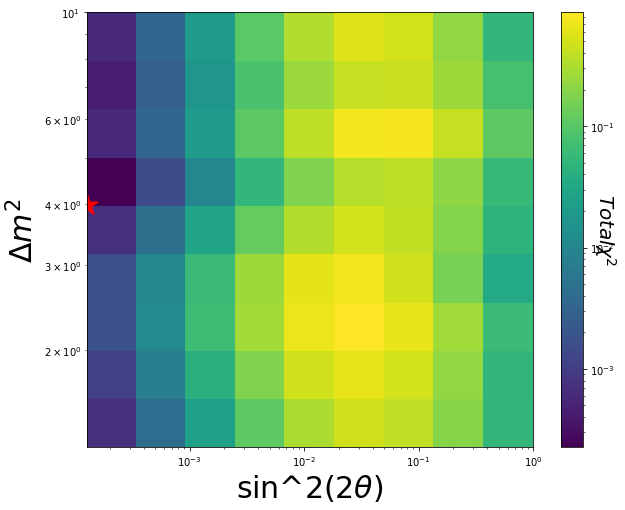

best m: 3.9810717055349722
best s: 0.00012589254117941674
0.00022705080907069829


In [7]:
# make CL plots
#setup the 2D grid with Numpy
import matplotlib.colors as colors
fig,ax = plt.subplots(figsize=(10,8))
y,x = np.meshgrid(m41_list, sin22theta_list)

#convert intensity (list of lists) to a numpy array for plotting
intensity = np.array(chi2_list)

#now just plug the data into pcolormesh
plt.pcolormesh(x, y, intensity,norm=colors.LogNorm(vmin=intensity.min(), vmax=intensity.max()))
cbar = plt.colorbar()
cbar.set_label(r'$Total \chi^2$',rotation=270,fontsize=20)
#contour plots
contours = plt.contour(x, y, confidence_arr,[.9,.99], colors='white',fontsize=20);

def fmt(x):
    s = f"{x*100:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"

label1 = plt.clabel(contours, contours.levels, inline=True, fmt=fmt, fontsize=10,rightside_up=False)

plt.scatter([bests],[bestm],color = 'red',marker='*',s=500)

plt.xlabel(r"sin^2(2$\theta$)",fontsize=30)
plt.ylabel(r"$\Delta m^2$",fontsize=30) 
plt.xscale("log")
plt.yscale("log")
plt.savefig('CLplot_statonly_210901.png')
plt.show()

print("best m:",bestm)
print("best s:",bests)
print(bestchi)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'fontsize'
  del sys.path[0]


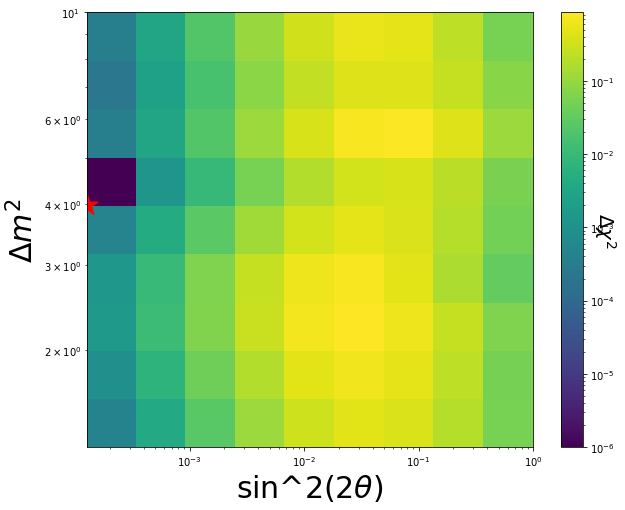

best m: 3.9810717055349722
best s: 0.00012589254117941674
0.00022705080907069829


In [8]:
# make CL plots
fig,ax = plt.subplots(figsize=(10,8))
y,x = np.meshgrid(m41_list, sin22theta_list)

#convert intensity (list of lists) to a numpy array for plotting
intensity = np.array(deltachi_arr)

#now just plug the data into pcolormesh
plt.pcolormesh(x, y, intensity,norm=colors.LogNorm(vmin=intensity.min(), vmax=intensity.max()))
cbar = plt.colorbar()
cbar.set_label(r'$\Delta\chi^2$',rotation=270,fontsize=20)
#contour plots
contours = plt.contour(x, y, confidence_arr,[.9,.99], colors='white',fontsize=20);

label1 = plt.clabel(contours, contours.levels, inline=True, fmt=fmt, fontsize=10,rightside_up=False)

plt.scatter([bests],[bestm],color = 'red',marker='*',s=500)

plt.xlabel(r"sin^2(2$\theta$)",fontsize=30)
plt.ylabel(r"$\Delta m^2$",fontsize=30) 
plt.xscale("log")
plt.yscale("log")
plt.savefig('CLplot_statonly_210901.png')
plt.show()

print("best m:",bestm)
print("best s:",bests)
print(bestchi)

In [7]:
# set up all of the plots to do for the best fit oscillation
varb_names = ['Enu_1e1p','Eta','PT_1e1p','AlphaT_1e1p',
              'SphB_1e1p','PzEnu_1e1p','ChargeNearTrunk',
              'Q0_1e1p','Q3_1e1p','Thetas','Phis','PTRat_1e1p',
              'Proton_ThetaReco','Proton_PhiReco',
              'MinShrFrac','MaxShrFrac',
              'BjXB_1e1p','BjYB_1e1p','Proton_Edep',
              'Electron_Edep',
              'Lepton_ThetaReco','Lepton_PhiReco',
              'OpenAng','Xreco','Yreco','Zreco',
              'sigprob','MPIDY_muon',
              'MPIDY_proton','MPIDY_eminus','shower_fraction',
              'Shower_Consistency',
              'EnuQE_lepton','EnuQE_proton',
              'Proton_TrackLength','Lepton_TrackLength','EnuTrue']

var_labels = [r'$E_\nu^{Range}$ [MeV]',r'$\eta$',r'Event $p_T$ [MeV]',r'$\alpha_T$',
              'QE Consistency',r'$p_z - E_\nu$ [MeV]','Charge Near Trunk',
              r'$Q_0$ [MeV]',r'$Q_3$ [MeV]',r'$\theta_e + \theta_p$',r'$|\phi_e - \phi_p|$',r'Event $p_T/p$',
              r'$\theta_p$',r'$\phi_p$',
              'Minimum Shower Fraction','Maximum Shower Fraction',
              'Bjorken X (Nucleon Rest Frame)','Bjorken Y (Nucleon Rest Frame)',r'$E_p$ [MeV]',
              r'$E_e$ [MeV]',
              r'$\theta_e$',r'$\phi_e$',
              'Opening Angle',r'$X_{reco}$',r'$Y_{reco}$','$Z_{reco}$',
              '1e1p BDT Score','Muon MPID Score (Y plane)',
              'Proton MPID Score (Y plane)','Electron MPID Score (Y plane)','Shower Fraction',
              'Shower Energy Consistency',
              r'$E_\nu^{Q-e}$',r'$E_\nu^{QE-p}$',
              'Proton Track Length [cm]','Lepton Track Length [cm]',r'$E_\nu^{True}$ [MeV]']

ranges = [ (200,2400),(0,0.6),(0,800),(0,np.pi),(0,5000),(-800,300),
           (0,800),(100,700),(0,1400),(0,2*np.pi),(0,2*np.pi),
           (0,1),(0,np.pi),(-np.pi,np.pi),(-1,1),(-1,1),(0,3),
           (0,1),(60,500),(35,1200),(0,np.pi),
           (-np.pi,np.pi),(0,np.pi),(0,256),(-117,117),(0,1036),
           (0.0,1.0),(0,1),(0,1),(0,1),(0,3),(0,5),
           (0,1200),(0,1200),(0,100),(0,200),(0,1200)]

varlabel_dict = {name:label for name,label in zip(varb_names,var_labels)}
range_dict = {name:rnge for name,rnge in zip(varb_names,ranges)}

range_dict['sigprob'] = (0.95,1.0)
    

In [8]:
# HELPER FUNCTIONS
detsystag = '1April2021'
dettag='3March2021_vA_fullLowE_withPi0Sample_newShowerCalib'
def getSysErrors(nbins,varName,mode,sigcut,rwtnameoverride=None,nsbmode=3):
    det_sys_m = np.loadtxt(Nickdir+'CovMatrices/DetVar/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/7September2021/covMatrix/avgscore/BDTcut0.95/detsys_Enu_1e1p_run13_cutMode3_cov_smooth.csv',delimiter=',')
#     det_sys_m = np.zeros((12,12))
    rwt_sys_m = np.loadtxt(Nickdir+'CovMatrices/RwghtSys/frac_covar_rewgt_highE.txt')
#     rwt_sys_m = np.zeros((12,12))
    rwt_sys_m = np.where(np.isnan(rwt_sys_m),0,rwt_sys_m)
    det_sys_m = np.where(np.isnan(det_sys_m),0,det_sys_m)
    return rwt_sys_m, det_sys_m

def getDetSysTot(det_sys_nue,nue,numu):
    det_sys_numu = np.diag(0.04*np.ones(det_sys_nue.shape[0]))
    tot = nue+numu
    return (det_sys_nue * np.outer(nue,nue) + det_sys_numu * np.outer(numu,numu))/np.outer(tot,tot)
    

def MakeBDTcut(idf,sigcut,mode,nBDTs,r2overlay=False,ttc=0.1):
    
    # Conglemerate BDT scores and weights based on strategy 
    
    bdtweight = np.zeros(idf.shape[0])
    sigprobmax = np.zeros(idf.shape[0]) 
    sigprobavg = np.zeros(idf.shape[0])
    sigprobmedian = np.zeros(idf.shape[0])
    sigproblist = np.zeros((idf.shape[0],nBDTs))
    notintrain = np.zeros((idf.shape[0],nBDTs),dtype=bool)
    numnottrain = np.zeros(idf.shape[0])
  
    for b in range(nBDTs):
        sp = idf['sigprob%i'%b]
        tvw = idf['tvweight%i'%b]
        sigprobmax = np.where(np.logical_and(tvw>0,sp>sigprobmax),sp,sigprobmax) # cut on the maximum non-train score in ensemble
        if mode == 'fracweight': 
            #bdtweight += np.where(sp>sigcut,tvw/float(nBDTs),0)
            bdtweight += np.where((tvw>ttc) & (sp>sigcut),1.0,0.0)
        sigprobavg += np.where(tvw>ttc,sp,0)
        numnottrain += np.where(tvw>ttc,1,0)
        sigproblist[:,b] = sp
        notintrain[:,b] = tvw > ttc
    sigprobavg /= np.where(numnottrain>0,numnottrain,1)
    for i,(tlist,siglist) in enumerate(zip(notintrain,sigproblist)):
        splist = siglist[tlist]
        if splist.size!=0: sigprobmedian[i] = np.median(splist)
        else: sigprobmedian[i] = 0
        
    idf['sigprobavg'] = sigprobavg
    idf['sigprobmedian'] = sigprobmedian
    idf['sigprobmax'] = sigprobmax

    
    if mode == 'avgscore':
        idf['sigprob'] = idf['sigprobavg']
        bdtweight = np.where(sigprobavg>sigcut,1,0)
    elif mode == 'medianscore':
        idf['sigprob'] = idf['sigprobmedian']
        bdtweight = np.where(sigprobmedian>sigcut,1,0)
    elif mode == 'fracweight':
        idf['sigprob'] = idf['sigprobmax']
        bdtweight /= np.where(numnottrain>0,numnottrain,1)
    
    idf['bdtweight'] = bdtweight
    
    # Drop duplicates
    
    idf.sort_values(by=['run','subrun','event','sigprob'],ascending=False,inplace=True)
    if r2overlay:
        idf.drop_duplicates(subset=['run','subrun','event','EnuTrue'],inplace=True)
    else:
        idf.drop_duplicates(subset=['run','subrun','event'],inplace=True)
    
def SaveTextFile(idf,run,filetag,sigcut,mode,tsavedir):
    nBDTs = int(idf['nBDTs'][0])
    MakeBDTcut(idf,sigcut,mode,nBDTs)
    idf.query('sigprob > @sigcut',inplace=True)
    savestr = 'eventlist_%s_run%i.txt'%(filetag,run)
    idf.to_csv(tsavedir+savestr,index=None,sep=' ')
    

# function to save full osc probabilities
def oscweights(df,sin22,m41,fullosc=True,remove=False):
    weights = [] 
    m =m41
    for i in range(len(df)):
        if fullosc==True:
            E=df['EnuTrue'].values[i]*1e-3
            z = df['Zreco'].values[i]*.01 - 5
            L= .47+(z*.001)
        
            sin2 = math.sin(1.27*((m*L)/E))
            sin1 = sin(sin22*2)
            P = sin2*sin2*sin22
            weights.append(P)
        elif remove==True:
            weights.append(0.0)
        else:
            weights.append(1.0)
        
    return weights
    
    

In [9]:
mu_cutoff = 0.46149198646840239

def chi2_cnp(M,mu):
    c2c=0
    if mu>0:
        if M != 0:
            c2c = (M - mu)**2/(3 / (2 / mu + 1 / M))
        else:
            c2c = mu/2#(M - mu)**2/(3 / (2 / mu + 1 / mu))
    return c2c

def chi2_pois(M,mu):
    c2c=0
    if mu > 0:
        if M != 0:
            c2c = 2*(mu - M + M*np.log(M/mu))
        else:
            c2c = 2*mu
    return c2c

def chi2_pears(M,mu):
    c2c=0
    if mu > 0:
        if M != 0:
            c2c = (M-mu)**2 / mu
        else:
            c2c = 2*mu
    return c2c

def chi2_thresh(M,mu,mode='cnp'):
    c2c=0
    if mu > mu_cutoff and mode=='cnp':
        c2c = chi2_cnp(M,mu)
    elif mu > mu_cutoff and mode=='pearson':
        c2c = chi2_pears(M,mu)
    else:
        c2c = chi2_pois(M,mu)
    return c2c

def cov_pois(M,mu):
    cov=0
    if mu > 0:
        if M != 0:
            cov = (M-mu)**2 / (2*(mu - M + M*np.log(M/mu)))
        else:
            cov = mu/2
    return cov

def cov_cnp(M,mu):
    cov=0
    if mu > 0:
        if M != 0:
            cov = (3 / (2 / mu + 1 / M))
        else:
            cov = mu/2
    return cov

def cov_pears(M,mu):
    cov=0
    if mu > 0:
        cov = mu
    return cov

def cov_thresh(M,mu,mode='cnp'):
    cov=0
    if mu>mu_cutoff and mode=='cnp':
        cov=cov_cnp(M,mu)
    elif mu>mu_cutoff and mode=='pearson':
        cov=cov_pears(M,mu)
    else:
        cov=cov_pois(M,mu)
    return cov


data
Data length! 32
ext
overlay
intrinsics
ncpi0
ccpi0
fullosc
overlay
intrinsics
fullosc
ext
ext
overlay
intrinsics
ncpi0
ccpi0
fullosc
[250.0, 350.0, 450.0, 550.0, 650.0, 750.0, 850.0, 950.0, 1050.0, 1150.0, 1400.0, 2000.0]
nullbins: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<Figure size 432x288 with 0 Axes>

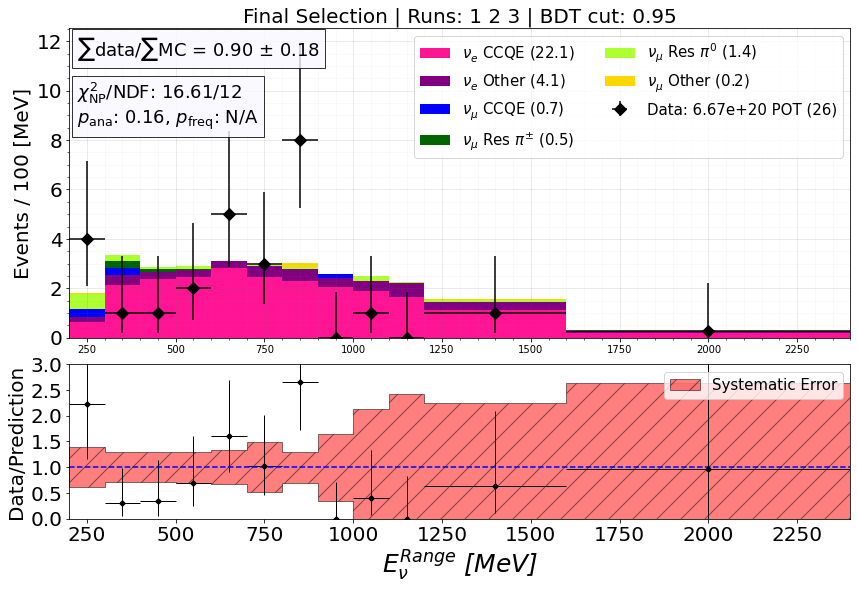

<Figure size 432x288 with 0 Axes>

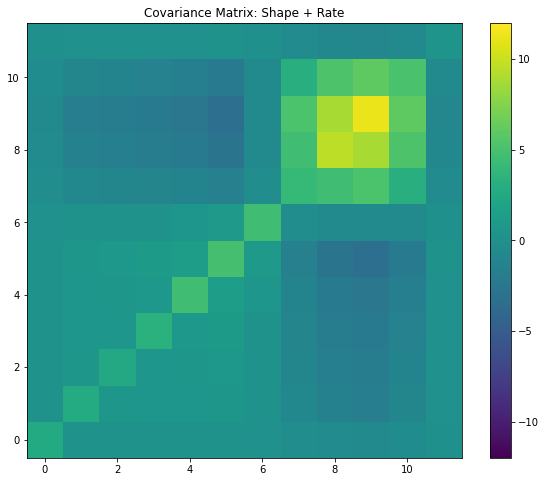

In [25]:
fudge_bkg = 1.0
fudge_sig = 1.0

plot_thresh = 0.05

# Near sideband stuff
nsbmode = 0 # 1 = Enu>500, 2 = 500<Enu<700, 3 = 0.7 < BDT < 0.95, 4 = 0.01 < BDT < 0.95
nsbrwtovr = None

#Binary Settings
sys     = True
usedata = True
plotPurity = False
topplot = False
pi0wplot = False
davioplot = False
makeCutData = False
shapeonly=False

#BDT Settings
bdtmode = 'avgscore'
nBDTs = 20
bdtpower = 0
bdtcutRange = [range_dict['sigprob'][0]]


runs_to_plot = [[1,2,3]]

POTdict = {1:{ft:DAT_POT1 for ft in filetaglist[1]},
           2:{ft:DAT_POT2 for ft in filetaglist[2]},
           3:{ft:DAT_POT3 for ft in filetaglist[3]}}

if cutMode in [2,3] or fset==12: 
    POTdict[1]['data'] = DATA_POT_TOT
    POTdict[2]['data'] = DATA_POT_TOT
    POTdict[3]['data'] = DATA_POT_TOT
    
pvalsa = []
pvalsf = []

cls  = ['deeppink','purple','blue','cyan','darkgreen','greenyellow','gold','brown','gray','fuchsia']

# set to best oscilation parameters
m41=bestm
sin41=bests
# m41=0
# sin41=0

for varName in varb_names:
    # only looking at Enu for now - need to get systematics for the rest still
    if varName not in ['Enu_1e1p']: continue
    if varName=='EnuTrue' and not finalPred: continue

    xlab = varlabel_dict[varName]

    bins  = [200,300,400,500,600,700,800,900,1000,1100,1200,1600,2400]
    numbins = len(bins)-1
    low   = (range_dict[varName])[0]
    high  = (range_dict[varName])[1]
    if nsbmode==2 and varName!='Enu_1e1p': numbins/=2


    for runs_included in runs_to_plot: # [run 1, run 2 run 3]

        pRatDict = {}
        pErrDict = {}

        for cut in bdtcutRange:

            if cutMode in [0,2] and varName=='sigprob': low = cut

            plotTitle = 'Final Selection | Runs:'
            plotFileName = varName
            FullPOT = 0
            POT1 = 0
            POT23 = 0

            vars_arr = []
            weights_arr = []
            labels_arr = []
            leew_arr = []
            Enu_arr = []

            dflist = []
            dfdat = pd.DataFrame()
            dflee = pd.DataFrame()
            dftot = pd.DataFrame()

            bkginttype = {}
            onvbkginttype = {}
            offvbkginttype = {}

            for r in runs_included:
                plotTitle += ' %i'%r
                plotFileName += '_%i'%r
                FullPOT += POTdict[r]['overlay']
                if r == 1: POT1 += POTdict[r]['overlay']
                elif r in [2,3]: POT23 += POTdict[r]['overlay']
                
                #loop to make cuts and set event weights
                for filetag in df[r].keys():
                    if not lowEpatch and 'lowE' in filetag: continue
                    if finalPred and filetag=='data': continue
                    dfc = df[r][filetag].copy()
                    print(filetag)
#                     if False:
                    if filetag!='data' or makeCutData:
                        MakeBDTcut(dfc,cut,bdtmode,nBDTs,(r==2 and filetag=='overlay'),ttc=0.1)
                    else:
                        dfc['sigprob'] = dfc['BDTscore_1e1p']
                        dfc['bdtweight'] = np.where(np.array(dfc['sigprob'])>cut,1,0)
                        dfc.sort_values(by=['run','subrun','event','sigprob'],ascending=False,inplace=True)
                        if r==2 and filetag=='overlay':
                            dfc.drop_duplicates(subset=['run','subrun','event','EnuTrue'],inplace=True)
                        else:
                            dfc.drop_duplicates(subset=['run','subrun','event'],inplace=True)

                    vars_arr += list(dfc[varName])
                    Enu_arr += list(dfc['Enu_1e1p'])
                    numu_l = np.core.defchararray.find(np.array(dfc['label'],dtype=np.string_),'m')!=-1
                    labels = np.where(np.logical_and(numu_l,dfc['scedr']>vtxCut),'offvtx',dfc['label'])

                    dfc['label'] = labels
                    labels_arr += list(labels)

                    if filetag=='fullosc':
                        oscprob=oscweights(dfc,sin41,m41,True,False)
                        dfc['oscprob']=oscprob
                    else:
                        oscprob=oscweights(dfc,.01,1.5,False,False)
                        dfc['oscprob']=oscprob

                    weights = dfc['GenieWeight'] * dfc['oscprob'] * dfc['POTweight']**(-1)
                    if cutMode in [0,2]: weights*= dfc['bdtweight'] * dfc['sigprob']**bdtpower
                    weights*=dfc['sigprob']>range_dict['sigprob'][0]
                    weights*=dfc['sigprob']<range_dict['sigprob'][1]
                    if nsbmode in [1,2]: weights*=dfc['Enu_1e1p']>500
                    if nsbmode==2: weights*=dfc['Enu_1e1p']<700
                    weights*=dfc['Enu_1e1p']<range_dict['Enu_1e1p'][1]
#                     add in weights for different binning
                    binweights=np.ones(len(weights))
                    for i in range(len(weights)):
                        enu = dfc['Enu_1e1p'].values[i]
                        if(enu<=1600 and enu>1200 ): 
                            binweights[i]*=1.0/4.0
                        if(enu>1600 and enu<=2400 ): 
                            binweights[i]*=1.0/8.0
                    weights*=binweights
                    
                    leeweights = dfc['LEEweight'] * weights

                    if filetag!='intrinsics': leeweights*=0

                    weights_arr += list(weights*POTdict[r][filetag])
                    leew_arr += list(leeweights*POTdict[r][filetag])

                    dfc_lee = dfc.copy()
                    dfc['weights'] = weights*POTdict[r][filetag]
                    dfc_lee['weights'] = leeweights*POTdict[r][filetag]

                    if filetag=='data':
                        dfdat = pd.concat((dfdat,dfc.query('weights>0')))
                        print("Data length!",len(dfdat))
                    else:
                        dflee = pd.concat((dflee,dfc_lee))
                        dftot = pd.concat((dftot,dfc))
                        dflist.append(dfc)


            datLab = "Data: {:.2e} POT".format(FullPOT)
            if(sys):
                rwt_sys_m,det_sys_m = getSysErrors(numbins,varName,bdtmode,cut,rwtnameoverride=nsbrwtovr,nsbmode=nsbmode)
                sys_label = 'Systematic Error'
      
            else:
                rwt_sys_m = np.zeros((numbins,numbins))
                det_sys_m = np.zeros((numbins,numbins))
                sys_label = 'MC Stat'

            if cutMode in [0,2]: plotTitle += r' | BDT cut: '+str(cut)

            label_arr = np.array(labels_arr)
            var_arr = np.array(vars_arr)
            enu_arr = np.array(Enu_arr)
            weight_arr = np.array(weights_arr)

            data = list(var_arr[label_arr=='data'])
            if nsbmode==1: dataOld = list(var_arr[np.logical_and(label_arr=='data',enu_arr>700)])
            nueO = list(var_arr[label_arr=='nue_ccqe'])
            nue = list(var_arr[label_arr=='nue_other'])
            ccqe = list(var_arr[label_arr=='numu_ccqe'])
            mec = list(var_arr[label_arr=='numu_mec'])
            pipm = list(var_arr[label_arr=='numu_pipm'])
            pi0 = list(var_arr[label_arr=='numu_pi0'])
            other = list(var_arr[label_arr=='numu_other'])
            dirtVar = []
            offv = list(var_arr[label_arr=='offvtx'])
            extVar = list(var_arr[label_arr=='EXTBNB'])
            lee = list(var_arr)

            ovrw1 = list(fudge_bkg*weight_arr[label_arr=='numu_ccqe'])
            ovrw2 = list(fudge_bkg*weight_arr[label_arr=='numu_mec'])
            ovrw3 = list(fudge_bkg*weight_arr[label_arr=='numu_pipm'])
            ovrw4 = list(fudge_bkg*weight_arr[label_arr=='numu_pi0'])
            ovrw5 = list(fudge_bkg*weight_arr[label_arr=='numu_other'])
            ovrw6 = list(fudge_bkg*weight_arr[label_arr=='offvtx'])
            ovrw7 = list(fudge_sig*weight_arr[label_arr=='nue_other'])
            ovrw8 = list(fudge_sig*weight_arr[label_arr=='nue_ccqe'])
            dirtw = []
            extw = list(weight_arr[label_arr=='EXTBNB'])
            leew = leew_arr
            datw = list(weight_arr[label_arr=='data'])
      
            # make data histogram
#             widths = [100,100,100,100,100,100,100,100,100,100,100,100,400,400,400]
#             widths = [100,100,100,100,100,100,100,100,100,100,100,100]
#             datw = [datw[i]/float(widths[i]) for i in range(numbins-1)]
            if (usedata):
                d = plt.hist(data,weights=datw,bins=bins,range=(low,high),density=0)
                xbins  = [(d[1][i]+d[1][i+1])/2.0 for i in range(len(d[1])-1)]
                print(xbins)
                xbin_edges = d[1]
                vals = d[0]
                valerrs = poisson_errors(vals)
                binwid = [50,50,50,50,50,50,50,50,50,50,200,400]
            else:
                d = [1.77,3.29,2.84,2.84,3.06,2.90,3.00,2.52,2.45,2.19,1.54,0.25]
                xbins  = [(bins[i]+bins[i+1])/2.0 for i in range(numbins)]
                print(xbins)
                xbin_edges = bins
                vals = np.array(d)
                valerrs = poisson_errors(vals)
                binwid = [50,50,50,50,50,50,50,50,50,50,200,400]
            plt.clf()
            
            wghs = [[x for x in ovrw8],
                    [x for x in ovrw7],
                    [x for x in ovrw1],
                    [x for x in  ovrw2],
                    [x for x in ovrw3],
                    [x for x in  ovrw4],
                    [x for x in ovrw5],
                    [x for x in dirtw],
                    [x for x in ovrw6],
                    [x for x in extw],
                    [x for x in leew]]

            mcErW = [[x**2 for x in ovrw8],
                     [x**2 for x in ovrw7],
                     [x**2 for x in ovrw1],
                     [x**2 for x in  ovrw2],
                     [x**2 for x in ovrw3],
                     [x**2 for x in  ovrw4],
                     [x**2 for x in ovrw5],
                     [x**2 for x in dirtw],
                     [x**2 for x in ovrw6],
                     [x**2 for x in extw]]


            r = plt.hist([nueO,nue,ccqe,mec,pipm,pi0,other,dirtVar,offv,extVar],bins=bins,range=(low,high),stacked='True',density=0,weights=mcErW)
            nueO_mcErr  = [sqrt(r[0][0][i]- 0) for i in range(numbins)]
            nue_mcErr   = [sqrt(r[0][1][i]-r[0][0][i]) for i in range(numbins)]
            ccqe_mcErr  = [sqrt(r[0][2][i]-r[0][1][i]) for i in range(numbins)]
            mec_mcErr   = [sqrt(r[0][3][i]-r[0][2][i]) for i in range(numbins)]
            pipm_mcErr  = [sqrt(r[0][4][i]-r[0][3][i]) for i in range(numbins)]
            pi0_mcErr   = [sqrt(r[0][5][i]-r[0][4][i]) for i in range(numbins)]
            other_mcErr = [sqrt(r[0][6][i]-r[0][5][i]) for i in range(numbins)]
            dirt_mcErr  = [sqrt(r[0][7][i]-r[0][6][i]) for i in range(numbins)]
            offv_mcErr  = [sqrt(r[0][8][i]-r[0][7][i]) for i in range(numbins)]
            ext_mcErr   = [sqrt(r[0][9][i]-r[0][8][i]) for i in range(numbins)]
            stkerr =  [sqrt( 
                       nueO_mcErr[i]**2  + 
                       nue_mcErr[i]**2  + 
                       ccqe_mcErr[i]**2  + 
                       mec_mcErr[i]**2  + 
                       pipm_mcErr[i]**2  + 
                       pi0_mcErr[i]**2  + 
                       other_mcErr[i]**2  + 
                       dirt_mcErr[i]**2 + 
                       offv_mcErr[i]**2 +  
                       ext_mcErr[i]**2 )
                       for i in range(numbins) 
                      ]
            stkerr = np.array(stkerr)
            bkgErr = sum([ (ccqe_mcErr[i]**2  + 
                       mec_mcErr[i]**2  + 
                       pipm_mcErr[i]**2  + 
                       pi0_mcErr[i]**2  + 
                       other_mcErr[i]**2  + 
                       dirt_mcErr[i]**2 + 
                       offv_mcErr[i]**2 +  
                       ext_mcErr[i]**2 )
                       for i in range(numbins) 
                      ])

            plt.clf()

            pli = plt.hist([nueO,nue,ccqe,mec,pipm,pi0,other,dirtVar,offv,extVar,lee],bins=bins,range=(low,high),weights=wghs,stacked='True',density=0)
            plt.clf()

            nums = [sum(x for x in pli[0][0]           ),
                    sum(x for x in pli[0][1] -pli[0][0]),
                    sum(x for x in pli[0][2] -pli[0][1]),
                    sum(x for x in pli[0][3] -pli[0][2]),
                    sum(x for x in pli[0][4] -pli[0][3]),
                    sum(x for x in pli[0][5] -pli[0][4]),
                    sum(x for x in pli[0][6] -pli[0][5]),
                    sum(x for x in pli[0][7] -pli[0][6]),
                    sum(x for x in pli[0][8] -pli[0][7]),
                    sum(x for x in pli[0][9] -pli[0][8]),        
                    sum(x for x in pli[0][10]-pli[0][9]),
                    sum(x for x in vals)
                    ]


            labs = [r'$\nu_e^{ }$ CCQE (%.1f)'%nums[0],
                    r'$\nu_e^{ }$ Other (%.1f)'%nums[1],
                    r"$\nu_\mu^{ }$ CCQE (%.1f)"%nums[2],
                    r"$\nu_\mu$ MEC (%.1f)"%nums[3],
                    r"$\nu_\mu$ Res $\pi^{\pm}$ (%.1f)"%nums[4],
                    r"$\nu_\mu$ Res $\pi^0$ (%.1f)"%nums[5],
                    r"$\nu_\mu^{ }$ Other (%.1f)"%nums[6],
                    r"Dirt$_{ }^{ }$ (%.1f)"%nums[7],
                    r"Off Vertex$_{ }^{ }$ (%.1f)"%nums[8],
                    "External (%.1f)"%nums[9]]


            # start of cov matrix and chi2 calculations
            cats = [ccqe,mec,pipm,pi0,other,dirtVar,offv,extVar]
            cats_to_plot = [nueO,nue]
            labs_to_plot = [labs[0],labs[1]]
            wghs_to_plot = [wghs[0],wghs[1]]
            cls_to_plot = [cls[0],cls[1]]
            other_to_plot = other
            other_wghs = wghs[6]
            other_num = nums[6]
            for i,(n,l,w,cl,c) in enumerate(zip(nums[2:10],labs[2:10],wghs[2:10],cls[2:10],cats)):
                if 'Other' in l: continue
                if n>plot_thresh:
                    cats_to_plot.append(c)
                    wghs_to_plot.append(w)
                    labs_to_plot.append(l)
                    cls_to_plot.append(cl)
                else:
                    other_to_plot+=c
                    other_num+=n
                    other_wghs+=w
            cats_to_plot.append(other_to_plot)
            cls_to_plot.append(cls[-4])
            labs_to_plot.append(r"$\nu_\mu^{ }$ Other (%.1f)"%other_num)
            wghs_to_plot.append(other_wghs)

            fig, ax = plt.subplots(figsize=(14,9.5))
            plt.subplot2grid((100,100),(0,0),colspan=100,rowspan=60)
#             wghs_to_plot = [w/float(binwid) for w in wghs_to_plot]
           
            p = plt.hist(cats_to_plot,bins=bins,range=(low,high),weights=wghs_to_plot,stacked='True',color=cls_to_plot,label=labs_to_plot,density=0)
#             pl =plt.hist(nueO+nue+ccqe+mec+pipm+pi0+other+dirtVar+offv+extVar+lee,bins=bins,range=(low,high),weights=wghs[0]+wghs[1]+wghs[2]+wghs[3]+wghs[4]+wghs[5]+wghs[6]+wghs[7]+wghs[8]+wghs[9]+wghs[10],stacked='False',histtype='step',lw=2,color='blue',ls='--',label="Unfolded MB Excess (%.1f)"%nums[10])
            nullhist = np.zeros((numbins))
#             for i in range(len(p[0][-1])):
                
#                 nullhist[i] = nullhist[j] + p[0][-1][i]
            print("nullbins:", nullhist)
            if not finalPred:
                #if nsbmode==1: plt.errorbar(xbins,valsOld,xerr=binwid/2,yerr=valerrsOld,marker='o',fillstyle='none',ls='None',color='black',ms=8,label=r"$E_\nu^{\rm Range}>700$ MeV (%i)"%sum(valsOld),elinewidth=1.5)
                plt.errorbar(xbins,vals,xerr=binwid,yerr=valerrs,marker='D',ls='None',color='black',ms=8,label="%s (%i)"%(datLab,nums[11]),elinewidth=1.5)
            
            ylow  = 0
            yhigh = 3.0*max(vals)
            if finalPred: 
                if varName=='Enu_1e1p': yhigh = 3*len(runs_included)
                else: yhigh = 2.0*max(p[0][-1])


            major_xticks = arange(low, high, 20)
            minor_xticks = arange(low, high*1.01, 5)
            major_yticks = arange(ylow, yhigh+1, 50)
            minor_yticks = arange(ylow, yhigh+1, 10)

            cov = np.zeros((numbins,numbins))
            if(shapeonly):
                sump = sum(p[0][-1])
                if (usedata):
                    sumd = sum(d[0])
                else:
                    sumd = sum(d)
                normp = sumd/sump
                print(normp)
            for j in range(numbins):
                cov[j][j] = cov_cnp(vals[j],p[0][-1][j]) + stkerr[j]**2
            

            # add in detector, flux< and xsec
            det_sys_m = getDetSysTot(det_sys_m,p[0][1],p[0][-1]-p[0][1])
            cov += det_sys_m * np.outer(p[0][-1],p[0][-1])
            cov += rwt_sys_m * np.outer(p[0][-1],p[0][-1])

            mask1D = np.where(p[0][-1]==0,False,True)
            mask2D = np.outer(mask1D,mask1D)#np.where(cov==0,False,True)

            Del = (vals - p[0][-1])[mask1D]
            cov = cov[mask2D].reshape((len(Del),len(Del)))
            
            if(shapeonly):
                normunc = cov.sum() / np.power(p[0][-1].sum(),2)
                for i in range(numbins):
                    for j in range(numbins):
                        cov[i][j] = cov[i][j] - p[0][-1][i]*p[0][-1][j]
                Del = (vals - p[0][-1]*normp)[mask1D]
          
            chi2 = np.matmul(np.matmul(Del,np.linalg.inv(cov)),Del)
            pval = 1 - stats.chi2.cdf(chi2,len(Del))

            pvalsa.append(pval)
            
            rwt_sys = np.array([rwt_sys_m[j][j] for j in range(numbins)])
            det_sys = np.array([det_sys_m[j][j] for j in range(numbins)])
            sys_errs = np.sqrt(rwt_sys + det_sys + stkerr**2/p[0][-1]**2)        

            sys_low = np.append((p[0][-1] * (1 - sys_errs)),0)

            rsys_low = np.append(1-sys_errs,(1-sys_errs)[-1])
            sys_high = np.append((p[0][-1] * (1 + sys_errs)),0)

            rsys_high = np.append(1+sys_errs,(1+sys_errs)[-1])

            sys_low = np.where(np.isnan(sys_low),0,sys_low)
            sys_high = np.where(np.isnan(sys_high),0,sys_high)
            rsys_low = np.where(np.isnan(rsys_low),1,rsys_low)
            rsys_high = np.where(np.isnan(rsys_high),1,rsys_high)
    
            plt.title(plotTitle,fontsize=20)
            plt.legend(loc='upper right',fontsize=15,ncol=2)
            plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.17)
            plt.minorticks_on()
            plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.07)
            plt.yticks(fontsize=20)
            ax.set_yticks(major_yticks)
#             plt.ylim((ylow,yhigh))
            plt.xlim((low,high))
            plt.ylabel("Events / 100 [MeV]",fontsize=20)

            if not finalPred:
                plt.annotate(r'$\sum$data/$\sum$MC = %.2f $\pm$ %.2f'%(vals.sum()/float(p[0][-1].sum()),np.sqrt(vals.sum())/float(p[0][-1].sum())),xy=(0.01,.91),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
                try:
                    plt.annotate(r'$\chi^2_{\rm NP}$/NDF: %2.2f/%i'%(chi2,len(Del))+'\n'+r'$p_{\rm ana}$: %2.2f, $p_{\rm freq}$: %2.2f'%(pval,float(freqp.query('varName==@varName')['p'])),xy=(0.01,.69),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
                    print(float(freqp.query('varName==@varName')['chi2']))
                    pvalsf.append(float(freqp.query('varName==@varName')['p']))
                except:
                    plt.annotate(r'$\chi^2_{\rm NP}$/NDF: %2.2f/%i'%(chi2,len(Del))+'\n'+r'$p_{\rm ana}$: %2.2f, $p_{\rm freq}$: N/A'%(pval),xy=(0.01,.69),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))


                if nsbmode==3 and varName=='Enu_1e1p':
                    plt.annotate(r'$\chi^2_{\rm NP,fit}$/NDF: %2.2f/%i'%(chi2fit,len(Del))+'\n'+r'$p_{\rm ana,fit}$: %2.2f'%(pvalfit),xy=(0.07,.49),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))




            plt.subplot2grid((100,100),(65,0),colspan=100,rowspan=30)

            rat    = [vals[i]/p[0][-1][i] for i in range(numbins)]
            highoscbins = [p[0][-1][i] for i in range(numbins)]
            
            raterr = ([valerrs[0][i]/p[0][-1][i] if p[0][-1][i] > 0 else sqrt(2) for i in range(numbins)],[valerrs[1][i]/p[0][-1][i] if p[0][-1][i] > 0 else sqrt(2) for i in range(numbins)])
            if not finalPred: plt.errorbar(xbins,rat,yerr=raterr,xerr=binwid,marker='D',ls='None',color='black',ms=4,elinewidth=1)

            plt.fill_between(xbin_edges,rsys_low,rsys_high,step='post',hatch='/',label=sys_label,color='red',edgecolor='black',alpha=0.5)

            plt.legend(loc='upper right',fontsize=15,ncol=1)
            plt.axhline(y=1.0,ls='--',color='blue')
            plt.xlabel(xlab,fontsize=25,style='italic')
            plt.ylabel("Data/Prediction",fontsize=20)
            plt.ylim((0,3))
            plt.xlim((low,high))
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            plt.savefig('BestSpec_statonly_210901.png')

            plt.show()
            plt.clf()
        
            sig = p[0][0]
            bkg = p[0][-1] - p[0][0]
            
            
fig = plt.figure(figsize=(10, 8))
plt.imshow(cov,vmin =-12,vmax=12)
plt.gca().invert_yaxis()
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_alpha(0)
ax.set_frame_on(False)
plt.colorbar(orientation='vertical')
if (shapeonly): plt.title('Covariance Matrix: Shape Only')
else: plt.title('Covariance Matrix: Shape + Rate')
plt.show()
plt.close()

In [ ]:
# y = [oscbins[i]/nooscbins[i] for i in range(bins)]
# y2 = [highoscbins[i]/nooscbins[i] for i in range(bins)]
# print(y)
# x = xbins
# plt.scatter(x,y,color='blue',label='sin^2 =.01')
# plt.scatter(x,y2,color='green',label='sin^2 =.05')
# plt.axhline(y=1.0,ls='--',color='red')
# plt.title('with oscillation/ no oscillation')
# plt.legend()
# plt.show()

In [ ]:
tsavedir = 'TextFiles/'+tag+'/'
try: os.mkdir(tsavedir)
except OSError as error: print(error)
tsavedir = 'TextFiles/'+tag+'/'+cutmodedir+'/'
try: os.mkdir(tsavedir)
except OSError as error: print(error)
for bdtmode in ['avgscore','fracweight','medianscore']:
    tsavedir = 'TextFiles/'+tag+'/'+cutmodedir+'/'+bdtmode+'/'
    try: os.mkdir(tsavedir)
    except OSError as error: print(error)
    for r in [1,2,3]:
        for filetag in df[r].keys():
            if not lowEpatch and 'lowE' in filetag: continue
            #if not 'data' in filetag: continue
            dfc = df[r][filetag].copy()
            SaveTextFile(dfc,r,filetag+'_fset%i'%fset,0.0,bdtmode,tsavedir)